In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import quilt3

from fish_morphology_code.analysis.notebook_utils import (
    DAY_18_COLOR,
    DAY_32_COLOR,
    DAY_COLOR_PALETTE,
    DAY_COLOR_PALETTE_THREE,
    BAR_PLOT_COLUMNS,
    SHORT_FEAT_NAME_MAP,
    BAR_PLOT_COLUMNS_SHORT,
    PROBE_ORDER,
    CI_EXTENT,
    FEATURE_TYPE_MAP,
    safe,
    get_regression_coef,
    boot_regression,
    ci_low,
    ci_high,
    make_reg_plot_ci_df,
    make_regression_bar_plot,
    get_pred_true,
    make_regression_scatter_plot,
    boot_spearmanr,
)

In [2]:
SAVE=True

if SAVE:
    SAVE_DIR = Path("./plots_feature_ablation")
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

    save_dir_pngs = SAVE_DIR/"pngs"
    save_dir_svgs = SAVE_DIR/"svgs"
    save_dir_pngs.mkdir(parents=True, exist_ok=True)
    save_dir_svgs.mkdir(parents=True, exist_ok=True)

In [3]:
p = quilt3.Package.browse(
    "aics/integrated_transcriptomics_structural_organization_hipsc_cm",
    "s3://allencell",
)
df = p["manuscript_plots"]["data.csv"]()

# from fish_morphology_code.analysis.collate_plot_dataset import collate_plot_dataset
# df = collate_plot_dataset()

Loading manifest: 100%|██████████| 8430/8430 [00:00<00:00, 31924.91entries/s]


### filter out nuc border cells

In [4]:
# df = df[~df["Nucleus touches FOV border"]]

### subset to columns we care about

In [5]:
cols_small = BAR_PLOT_COLUMNS + [
    "Expert structural annotation score (mean)",
    "Combined organizational score",
    "Cell age",
#     "Experiment Round",
]

df_small = df[cols_small].copy()

### make separate dfs for each round

In [6]:
# df_r1_small = df_small[df_small["Experiment Round"] == 1]
# df_r2_small = df_small[df_small["Experiment Round"] == 2]

### fit scale on first round and transform both

In [7]:
from sklearn.preprocessing import StandardScaler

df_small_reg = df_small.copy()
# df_r1_small_reg = df_r1_small.copy()
# df_r2_small_reg = df_r2_small.copy()

scaler = StandardScaler()
# scaler.fit(df_r1_small[BAR_PLOT_COLUMNS])
scaler.fit(df_small[BAR_PLOT_COLUMNS])

# df_r1_small_reg[BAR_PLOT_COLUMNS] = scaler.transform(df_r1_small_reg[BAR_PLOT_COLUMNS])
# df_r2_small_reg[BAR_PLOT_COLUMNS] = scaler.transform(df_r2_small_reg[BAR_PLOT_COLUMNS])

df_small_reg[BAR_PLOT_COLUMNS] = scaler.transform(df_small[BAR_PLOT_COLUMNS])

In [8]:
# df_r1_small_reg.shape
# df_r2_small_reg.shape

df_small_reg.shape

(4775, 14)

### define regression procedure

In [9]:
from sklearn import linear_model

def make_regression(
    scaled_data=pd.DataFrame(),
    y_col='Expert structural annotation score (mean)',
    X_cols=BAR_PLOT_COLUMNS,
    weight_y=True,
    alpha=0.001,
):
    X = scaled_data[X_cols]        
    y = scaled_data[y_col]

    if weight_y:
        class_weights = {
            v: len(y) / c for v, c in zip(*np.unique(y, return_counts=True))
        }
        sample_weights = scaled_data[y_col].map(class_weights)
    else:
        sample_weights = 1

    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(X, y, sample_weight=sample_weights)
    
    return reg

In [10]:
reg = make_regression(df_small_reg)

In [11]:
# df_small['COS_2'] = np.concatenate(
#     [
#         reg.predict(df_r1_small_reg[BAR_PLOT_COLUMNS]),
#         reg.predict(df_r2_small_reg[BAR_PLOT_COLUMNS])
#     ]
# )

df_small['COS_2'] = reg.predict(df_small_reg[BAR_PLOT_COLUMNS])

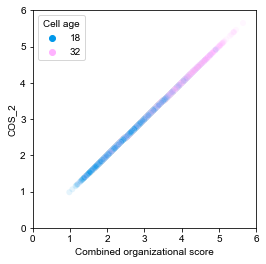

In [12]:
dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
ax = sns.scatterplot(
    data=df_small.sample(frac=1,replace=False,),
    x="Combined organizational score",
    y="COS_2",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    alpha=0.1
);

ax.set(
    xlim=(0, 6),
    ylim=(0, 6),
);

In [13]:
np.isclose(
    df_small["Combined organizational score"],
    df_small["COS_2"],
    
).all()

True

In [14]:
feature_sets = {
    c:[c] for c in BAR_PLOT_COLUMNS
}

feature_sets["All"] = [k for k,v in FEATURE_TYPE_MAP.items()]

sets = [
    ['Cell features'],
    ['Global alignment'],
    ['Local organization'],
    ['Cell features', 'Global alignment'],
    ['Cell features', 'Local organization'],
    ['Global alignment', 'Local organization'],
]
for s in sets:
    feature_sets[" + ".join(s)] = [k for k,v in FEATURE_TYPE_MAP.items() if v in s]

In [15]:
df_ablated_scores = pd.DataFrame(columns = feature_sets.keys())

for name, fset in feature_sets.items():
    
    # copy regression input to tmp
    df_tmp = df_small_reg.copy()
    
    # zero out columns not in this feature set
    for col in BAR_PLOT_COLUMNS:
        if col not in fset:
            df_tmp[col]=0
            
    # make predictions with ablated model
    preds = reg.predict(df_tmp[BAR_PLOT_COLUMNS])
    
    df_ablated_scores[name] = preds
    
df_ablated_scores_age = pd.concat([df_ablated_scores, df_tmp[["Cell age"]]], axis="columns")

In [16]:
np.allclose(df_ablated_scores["All"], df_small_reg["Combined organizational score"])

True

In [17]:
df_ablated_corr = df_ablated_scores.corr(
    method="spearman"
)["All"].to_frame(
).drop(
    ["All"]
).reset_index(
).rename(
    columns={
        "index": "Feature set",
        "All": "Spearman correlation with COS"
    }
)

In [18]:
pallette_corr_grey = {k:"grey" for k,v in feature_sets.items() if len(v) == 1}
pallette_corr_colors = {
    'Cell features': "red",
    'Global alignment': "yellow",
    'Local organization': "blue",
    'Cell features + Global alignment': "orange",
    'Cell features + Local organization': "purple",
    'Global alignment + Local organization': "green",
}
pallette_corr = {**pallette_corr_grey, **pallette_corr_colors}

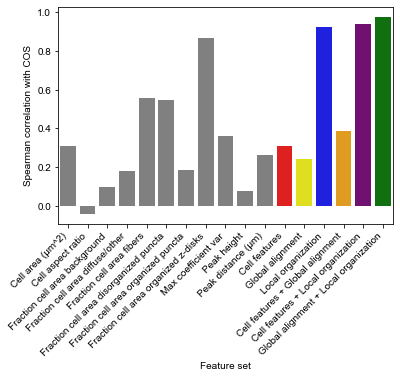

In [19]:
plt_ablation_corr = sns.barplot(
    data=df_ablated_corr,
    x="Feature set",
    y="Spearman correlation with COS",
    palette=pallette_corr
)

plt_ablation_corr.set_xticklabels(
    plt_ablation_corr.get_xticklabels(), rotation=45, horizontalalignment="right"
);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'feature_corr_with_cos.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'feature_corr_with_cos.svg', format="svg", bbox_inches = "tight")

## try to predict cell age from different ablated models

In [20]:
from sklearn.metrics import balanced_accuracy_score

df_age_pred = pd.DataFrame(index=df_ablated_scores.columns, columns=["Cell age balanced prediction accuracy"])

y = df_ablated_scores_age["Cell age"]
for col in df_ablated_scores.columns:
    clf = linear_model.LogisticRegression(penalty='l2', C=1, class_weight="balanced",)
    clf.fit(df_ablated_scores_age[[col]], df_ablated_scores_age["Cell age"])
    y_pred = clf.predict(df_ablated_scores_age[[col]])
    acc = balanced_accuracy_score(df_ablated_scores_age["Cell age"], y_pred)
    df_age_pred.at[col, "Cell age balanced prediction accuracy"] = acc
df_age_pred = df_age_pred.reset_index().rename(columns={"index":"Feature set"})

In [21]:
palette_age_pred_grey = {k:"grey" for k,v in feature_sets.items() if len(v) == 1}
palette_age_pred_colors = {
    'All': "black",
    'Cell features': "red",
    'Global alignment': "yellow",
    'Local organization': "blue",
    'Cell features + Global alignment': "orange",
    'Cell features + Local organization': "purple",
    'Global alignment + Local organization': "green",
}
palette_age_pred = {**palette_age_pred_grey, **palette_age_pred_colors}

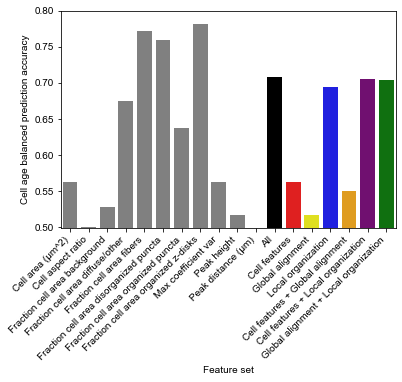

In [22]:
plt_age_pred = sns.barplot(
    data=df_age_pred,
    x="Feature set",
    y="Cell age balanced prediction accuracy",
    palette=palette_age_pred
)

plt_age_pred.set_xticklabels(
    plt_age_pred.get_xticklabels(), rotation=45, horizontalalignment="right"
);

plt_age_pred.set(
    ylim=(0.499, 0.80),
);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'age_pred.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'age_pred.svg', format="svg", bbox_inches = "tight")

## Heatmaps

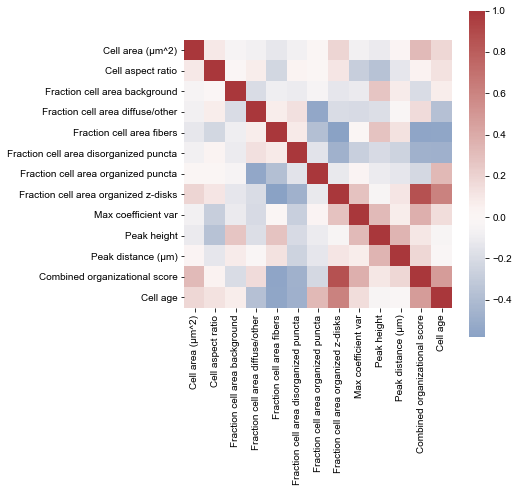

In [23]:
plt.figure(figsize=(6,6))

ax = sns.heatmap(
    df_small.drop(
        columns=["COS_2", 'Expert structural annotation score (mean)']
    ).corr(),
    cmap="vlag",
    square=True,
    center=0
)

In [24]:
feat_type_map_all = {**FEATURE_TYPE_MAP, **{'Combined organizational score':"Aggregate metric", 'Cell age':"Age"}}
# network_colors = pd.Series(network_labels, index=df.columns).map(network_lut)
feature_type_series = pd.Series(feat_type_map_all)

In [25]:
type_pal = sns.color_palette("Set2")[:len(set(feat_type_map_all.values()))]
type_lut = dict(zip(set(feat_type_map_all.values()), type_pal))
feat_type_colors = pd.DataFrame({"Feature type":pd.Series(feat_type_map_all).map(type_lut)})

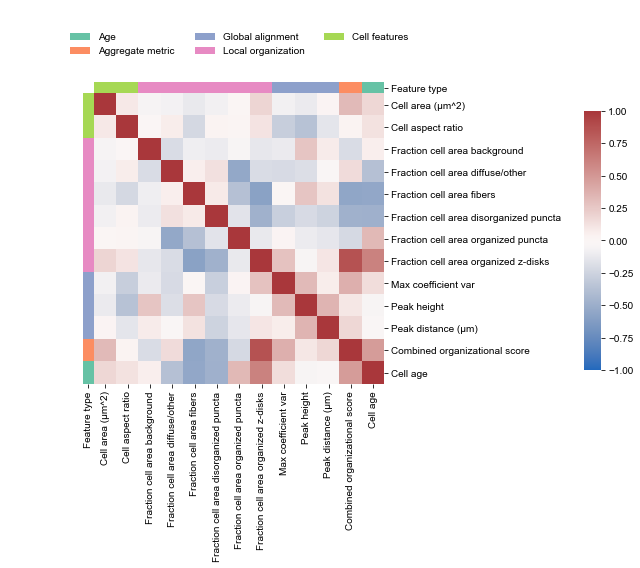

In [26]:
g = sns.clustermap(
    df_small.drop(
        columns=["COS_2", 'Expert structural annotation score (mean)']
    ).corr(),
    cmap="vlag",
    vmin=-1,
    vmax=1,
    row_cluster=False,
    col_cluster=False,
    row_colors=feat_type_colors,
    col_colors=feat_type_colors,
    figsize=(8,8),
)

# Draw the legend bar for the classes                 
for label, color in type_lut.items():
    g.ax_col_dendrogram.bar(
        0,
        0,
        color=color,
        label=label,
        linewidth=0
    )
g.ax_col_dendrogram.legend(
    frameon=False,
    loc="center",
    ncol=3
)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([1.02, .35, .03, .45])

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'overall_corr_heatmap.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'overall_corr_heatmap.svg', format="svg", bbox_inches = "tight")

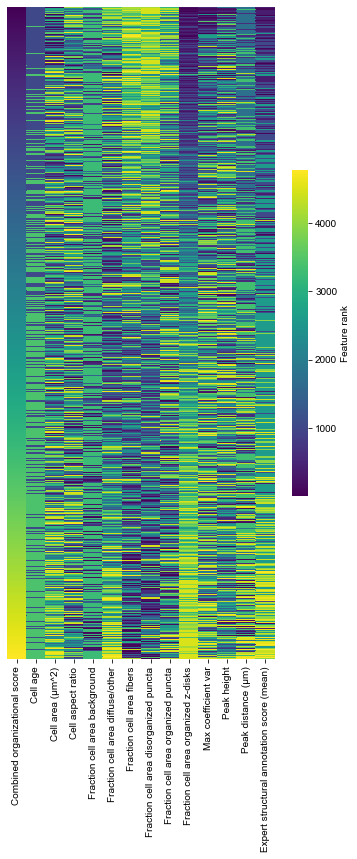

In [27]:
first_cols = ['Combined organizational score', 'Cell age']

plt.figure(figsize=(6,12))
ax = sns.heatmap(
    df_small_reg[first_cols + [c for c in df_small_reg.columns if c not in first_cols]].rank(
        ascending=False
    ).sort_values(
        by='Combined organizational score'
    ),
    cmap="viridis",
    cbar_kws={'label': 'Feature rank', "shrink": .5},
    yticklabels=False
);

ax.tick_params(left=False, bottom=True)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'feature_heatmap.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'feature_heatmap.svg', format="svg", bbox_inches = "tight")

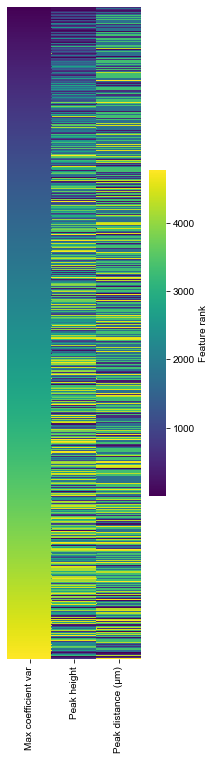

In [28]:
plt.figure(figsize=(3,12))
ax = sns.heatmap(
    df_small_reg[[k for k,v in FEATURE_TYPE_MAP.items() if v == 'Global alignment']].rank(
        ascending=False
    ).sort_values(
        by='Max coefficient var'
    ),
    cmap="viridis",
    cbar_kws={'label': 'Feature rank', "shrink": .5},
    yticklabels=False
);

ax.tick_params(left=False, bottom=True) ## other options are right and top

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'feature_heatmap_gs.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'feature_heatmap_gs.svg', format="svg", bbox_inches = "tight")

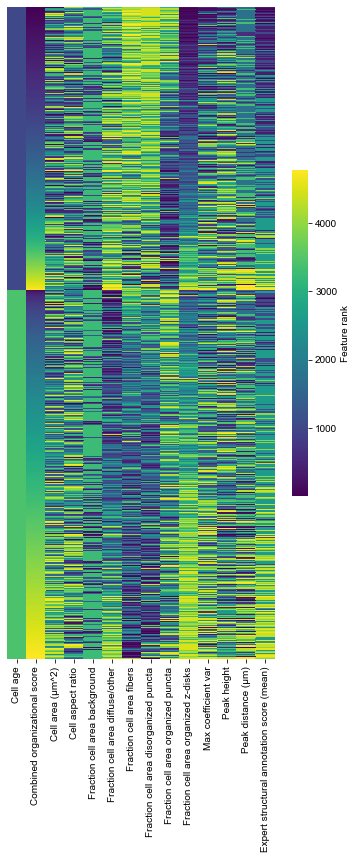

In [29]:
first_cols = ['Cell age', 'Combined organizational score']

plt.figure(figsize=(6,12))
ax = sns.heatmap(
    df_small_reg[first_cols + [c for c in df_small_reg.columns if c not in first_cols]].rank(
        ascending=False
    ).sort_values(
        by=first_cols
    ),
    cmap="viridis",
    cbar_kws={'label': 'Feature rank', "shrink": .5},
    yticklabels=False
);

ax.tick_params(left=False, bottom=True)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'feature_heatmap.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'feature_heatmap.svg', format="svg", bbox_inches = "tight")

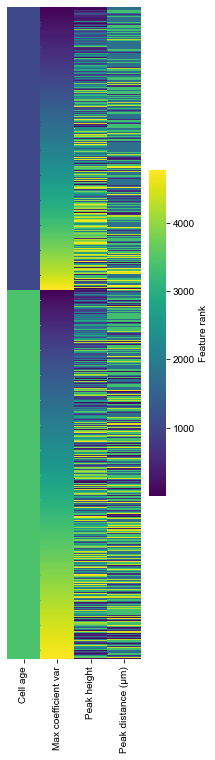

In [30]:
plt.figure(figsize=(3,12))
ax = sns.heatmap(
    df_small_reg[['Cell age']+[k for k,v in FEATURE_TYPE_MAP.items() if v == 'Global alignment']].rank(
        ascending=False
    ).sort_values(
        by=['Cell age', 'Max coefficient var']
    ),
    cmap="viridis",
    cbar_kws={'label': 'Feature rank', "shrink": .5},
    yticklabels=False
);

ax.tick_params(left=False, bottom=True) ## other options are right and top

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'feature_heatmap_gs.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'feature_heatmap_gs.svg', format="svg", bbox_inches = "tight")